In [ ]:
import os
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay, recall_score
from sklearn.model_selection import train_test_split
RANDOM_STATE=0

##Read Data

In [ ]:
output = 'Dataset.csv'
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1kzuh8CAZ3zZhG2RyeWq_eL6sKA_1V0I8",
    output, 
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1kzuh8CAZ3zZhG2RyeWq_eL6sKA_1V0I8
To: /content/Dataset.csv
100%|██████████| 494M/494M [00:05<00:00, 86.3MB/s]


'Dataset.csv'

In [ ]:
Data = pd.read_csv('Dataset.csv')

##Preprocesamiento

In [ ]:
Data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Se ve que tengo 3 variables categóricas:


1.   type
2.   nameOrig
3.   nameDest





In [ ]:
Data.value_counts(['isFraud'])

isFraud
0          6354407
1             8213
dtype: int64

Veo que solo 8213 registros de un total de 6362619 fueron clasificados como fraude. Esto representa un 0,129%. Se evidencia que el dataset se encuentra fuertemente desbalanceado.

In [ ]:
Data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
Data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

El Dataset no tienen valores Null ni NaN

Debo verificar si existe alguna correlación entre las variables categóricas y la variable destino (isFraud)

In [ ]:
Crosstab = pd.crosstab(index=Data['type'], columns=Data['isFraud'])
Crosstab

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


Se observa que los fraudes se producen únicamente con las transacciones del tipo CASH_OUT y TRANSFER, es decir extracciones de efectivo y transferencias.

In [ ]:
Crosstab2 = pd.crosstab(index=Data['type'], columns=Data['isFlaggedFraud'])
Crosstab2

isFlaggedFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2237500,0
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,532893,16


De las 8213 transacciones que resultaron ser fraude, sólo 16 fueron etiquetadas como tal y únicamente en el tipo transferencia.

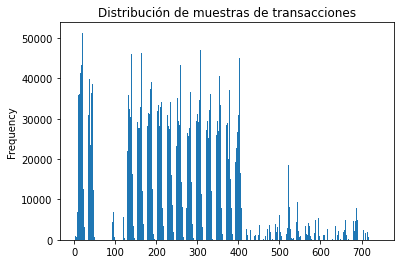

In [ ]:
registro_horario = Data['step'].to_numpy()[-1]
ax = Data['step'].plot.hist(bins=registro_horario,title = 'Distribución de muestras de transacciones')

Como la variable medidas en horas acumulativas, no me ayuda a comprender el problema, voy a generar un nuevo feature con la hora en segmentos de 24hs.

In [ ]:
types = list(set(Data['type']))
type_dict={}

for i, t in enumerate(types):
    type_dict[t] = i

Data['type_id'] = [type_dict[t] for t in  Data['type'] ]

day_moment = np.array((Data['step']/24 - (Data['step']/24).astype(int))*24,int)
Data3 = Data
Data['day_moment'] = day_moment

In [ ]:
Data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_id,day_moment
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,4,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1


In [ ]:
Data['day_moment'].value_counts()

18    918575
12    721722
15    628613
9     502303
19    501661
13    405457
16    374836
10    368116
20    361815
21    349596
17    294790
11    284820
14    264366
22    144752
23     89270
0      85166
8      21213
1      17389
7      14586
2       5161
6       3524
3       2087
4       2037
5        765
Name: day_moment, dtype: int64

###Análisis gráficos preliminares

Analizo la distribución de los fraudes a lo largo de las 24hs del día

Text(0.5, 1.0, 'Distribucion horaria de la muestra')

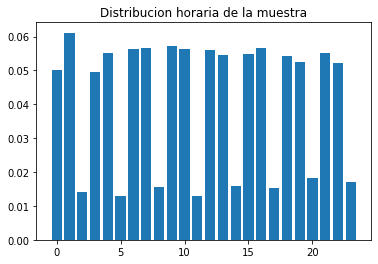

In [ ]:
sum_fraud_per_h = []
for h in list(set(Data['day_moment'])):
    hora = Data[Data['day_moment'] == h]
    sum_fraud_per_h.append(hora['isFraud'].sum())

sum_fraud_per_h = np.array(sum_fraud_per_h)
plt.figure()
plt.bar(range(0,24),sum_fraud_per_h/np.sum(sum_fraud_per_h))
plt.title('Distribucion horaria de la muestra')

Se observa que existe alguna relación entre la hora del día y la cantidad de transacciones fraudulentas.

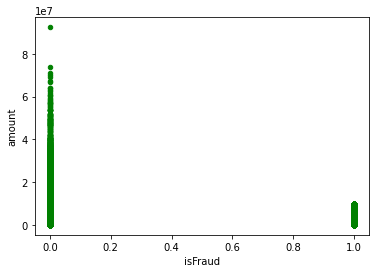

In [ ]:
Data.plot.scatter(x='isFraud', y='amount', color='green')

In [ ]:
Fraudes = Data['isFraud']==1
Data_fraudes = Data[Fraudes]
Data_fraudes.max(axis=0)

step                       743
type                  TRANSFER
amount              10000000.0
nameOrig             C99979309
oldbalanceOrg      59585040.37
newbalanceOrig     49585040.37
nameDest            C999955448
oldbalanceDest    236230516.82
newbalanceDest    236726494.66
isFraud                      1
isFlaggedFraud               1
type_id                      4
day_moment                  23
dtype: object

In [ ]:
Data_fraudes.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_id,day_moment
count,8213.000000,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8213.0,8213.000000,8213.000000,8213.000000
mean,368.413856,1.467967e+06,1.649668e+06,1.923926e+05,5.442496e+05,1.279708e+06,1.0,0.001948,2.503470,11.222574
std,216.388690,2.404253e+06,3.547719e+06,1.965666e+06,3.336421e+06,3.908817e+06,0.0,0.044097,1.500087,6.882469
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000,1.000000,0.000000
25%,181.000000,1.270913e+05,1.258224e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000,1.000000,6.000000
50%,367.000000,4.414234e+05,4.389835e+05,0.000000e+00,0.000000e+00,4.676420e+03,1.0,0.000000,4.000000,12.000000
75%,558.000000,1.517771e+06,1.517771e+06,0.000000e+00,1.478287e+05,1.058725e+06,1.0,0.000000,4.000000,17.000000
max,743.000000,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.0,1.000000,4.000000,23.000000


Observo que los fraudes se realizan por montos bajos (10.000.000), frente a 92.445.520.
Por otro lado, observo que existe almenos una transacción por monto 0, el cual es considerado fraude. Esto puede ser una prueba de los estafadores.

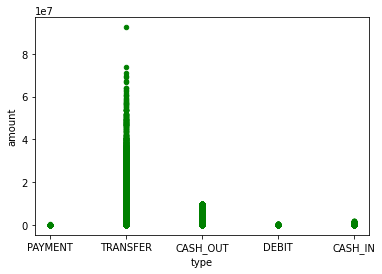

In [ ]:
Data.plot.scatter(x='type', y='amount', color='green')

Los tipos de transacciones donde se desarrollan los fraudes, también son las transacciones con mayor importe en las transacciones. Esto, en conjunto con los bajos valores de los fraudes, pueden dificultar la detección de los mismos.

###Correlación entre variables

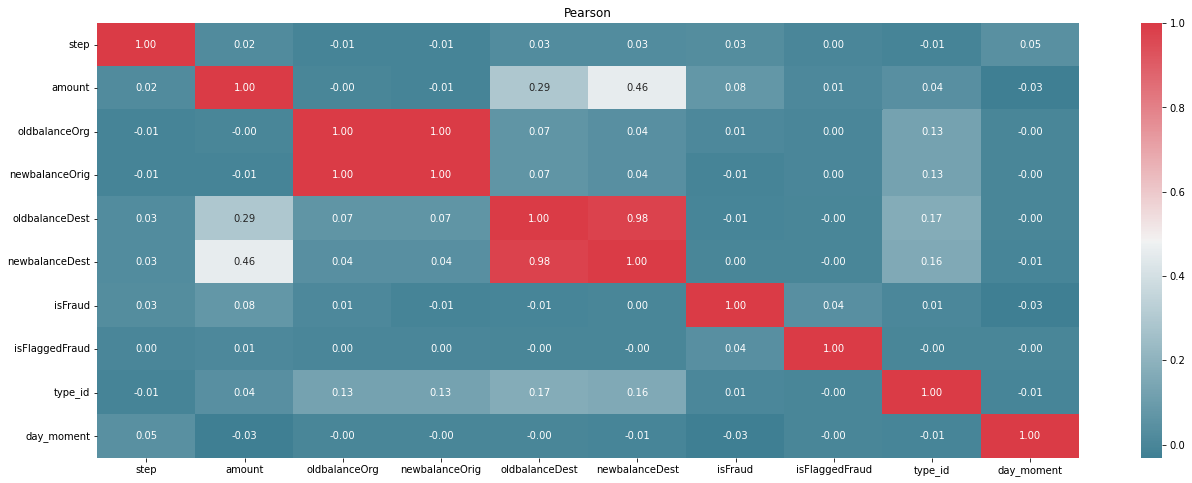

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1,1,figsize=(22,8))

tau = Data.corr(method='pearson')
axes.set_title("Pearson")
sns.heatmap(tau, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

No se observa gran correlación entre las variables y la variable objetivo. Puedo decir, que la mayor existe con amount seguidamente por isFlaggedFraud.
No descartaré ninguna variable, ya que no se observan motivos para descartar unas u otras. Se podría descartar, llegado el caso newbalanceDest, oldbalanceOrg, newbalanceOrg, oldbalanceDest, type_id

In [ ]:
Data2 = Data.drop({'type_id'}, axis=1)

In [ ]:
Data2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_moment
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1


###Variables Dummies

Debido a que nameOrig y nameDest son los usuarios que generan y reciben la transacción, analizo cuantas diferentes poisibilidades tienen estas dos variables.

In [ ]:
n = Data2.nunique(axis=0) 
print("Cantidad de valores diferentes en cada columna :\n", n)

Cantidad de valores diferentes en cada columna :
 step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
day_moment             24
dtype: int64


Es evidente que no se puede realizar un one hot encoding a las variables *nameOrig* ni *nameDest* debido a la cantidad de diferentes valores que éstas pueden tomar.

Unicamente realizaré variable dummy a *type*.

In [ ]:
# Generamos las variables dummies para los datos categóricos.
Data_dummy = pd.get_dummies(Data2['type'],drop_first=False);
Data2 = pd.concat([Data2,Data_dummy],axis=1)
Data2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_moment,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0,0,0,1,0


In [ ]:
Data2 = Data2.drop({'type'}, axis=1)
Data2 = Data2.drop({'nameOrig'}, axis=1)
Data2 = Data2.drop({'nameDest'}, axis=1)

In [ ]:
Data2.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_moment,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,0,0,1,0


Divido el dataset en Train y Test con stratificación

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Data2.drop(['isFraud'], axis=1), Data2['isFraud'], stratify = Data2['isFraud'], random_state = RANDOM_STATE)

In [ ]:
print('Entrenamiento:', X_train.shape)
print('Testeo:', X_test.shape)
print('\n train:')
print(y_train.value_counts(normalize=False))
print('\n test:')
print(y_test.value_counts(normalize=False))

Entrenamiento: (4771965, 13)
Testeo: (1590655, 13)

 train:
0    4765805
1       6160
Name: isFraud, dtype: int64

 test:
0    1588602
1       2053
Name: isFraud, dtype: int64


In [ ]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,day_moment,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
5802674,401,304100.04,11346.00,0.00,1664077.86,2220781.28,0,16,0,1,0,0,0
3224046,250,183437.53,4151993.06,4335430.59,8729501.77,8546064.24,0,9,1,0,0,0,0
2207508,186,47116.34,26121.00,0.00,440267.01,1063203.39,0,18,0,1,0,0,0
371673,17,374100.75,0.00,0.00,1052276.11,1426376.86,0,17,0,1,0,0,0
1990765,179,175571.65,0.00,0.00,1943834.90,2119406.55,0,10,0,1,0,0,0


Se observa el desbalance que existe entre fraudes y no fraudes. A continuación realizo el balance entre clases por undersampling referenciado a la clase mayoritaria

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
undersampler=RandomUnderSampler(sampling_strategy='majority');

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_us.value_counts())

Composición del training set:
0    6160
1    6160
Name: isFraud, dtype: int64


In [ ]:
undersampler=RandomUnderSampler(sampling_strategy='majority');

X_test_us,y_test_us=undersampler.fit_resample(X_test,y_test);

print('\nComposición del test set:')
print(y_test_us.value_counts())


Composición del test set:
0    2053
1    2053
Name: isFraud, dtype: int64


In [ ]:
X_test_us.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,day_moment,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,210,61209.17,209157.0,270366.17,6088655.61,6027446.44,0,18,1,0,0,0,0
1,209,145428.48,22254.0,0.00,168414.73,313843.21,0,17,0,0,0,0,1
2,130,18417.23,0.0,0.00,284073.67,302490.90,0,10,0,1,0,0,0
3,321,349123.50,0.0,0.00,1596461.68,1945585.17,0,9,0,1,0,0,0
4,372,16569.73,0.0,0.00,0.00,0.00,0,12,0,0,0,1,0


In [ ]:
X_test_us2 = X_test_us.drop({'day_moment'}, axis=1)

In [ ]:
X_train_us2 = X_train_us.drop({'day_moment'}, axis=1)

#Modelos

##Regreción Logística

In [ ]:
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()  
    
    X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegressionCV(scoring='f1')
    
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

    #plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

    return model, X_test_sc

In [ ]:
model, X_test_sc = logistic_regression_report(X_train_us2,X_test_us2,y_train_us,y_test_us)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2053
           1       0.95      0.98      0.96      2053

    accuracy                           0.96      4106
   macro avg       0.96      0.96      0.96      4106
weighted avg       0.96      0.96      0.96      4106

Area bajo la curva ROC: 0.993
Area bajo la curva Precision-Recall: 0.9927


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


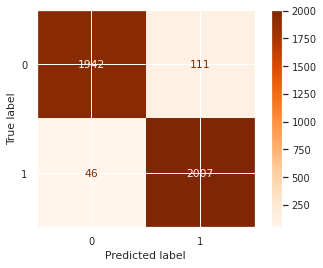

In [ ]:
plot_confusion_matrix(model,X_test_sc,y_test_us,cmap='Oranges');

Veo que 2008 de los 2053 fraudes son detectados. Pero en contra tengo que 105 transacciones son vistas como fraudes, cuando en realidad no lo son.

Accuracy = 0.96

Precision = 0.95

Recall = 0.98

True negative = 0.95

Cómo vi que existe una correlación entre el momento del día y los fraudes, agrego una columna con momento del día y vuelvo a realizar la logistic regression.

In [ ]:
model2, X_test_sc = logistic_regression_report(X_train_us,X_test_us,y_train_us,y_test_us)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2053
           1       0.95      0.97      0.96      2053

    accuracy                           0.96      4106
   macro avg       0.96      0.96      0.96      4106
weighted avg       0.96      0.96      0.96      4106

Area bajo la curva ROC: 0.9936
Area bajo la curva Precision-Recall: 0.9934


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


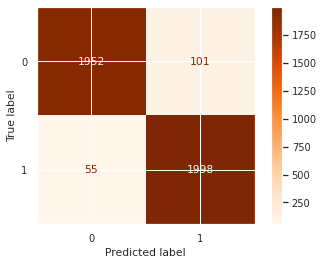

In [ ]:
plot_confusion_matrix(model2,X_test_sc,y_test_us,cmap='Oranges');

Accuracy = 0.97

Precision = 0.96

Recall = 0.98

True negative = 0.96

Se observa una mejoría leve en el recall y accuracy

##SVM

SVM sin day_moment

In [ ]:
from sklearn.svm import SVC
def SVM_report(X_train,X_test,y_train,y_test):
        
    model=SVC(random_state=0, class_weight='balanced')
    
    model.fit(X_train,y_train)

    pred = model.predict(X_test)
    plt.figure()
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print(classification_report(y_test, pred))

<Figure size 432x288 with 0 Axes>

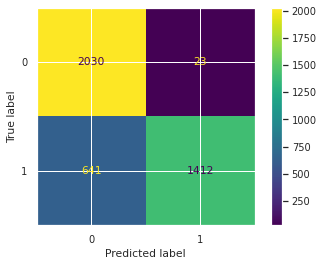

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2053
           1       0.98      0.69      0.81      2053

    accuracy                           0.84      4106
   macro avg       0.87      0.84      0.83      4106
weighted avg       0.87      0.84      0.83      4106



In [ ]:
SVM_report(X_train_us2,X_test_us2,y_train_us,y_test_us)

SVM con day_moment

<Figure size 432x288 with 0 Axes>

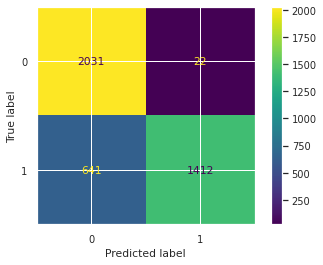

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2053
           1       0.98      0.69      0.81      2053

    accuracy                           0.84      4106
   macro avg       0.87      0.84      0.83      4106
weighted avg       0.87      0.84      0.83      4106



In [ ]:
SVM_report(X_train_us,X_test_us,y_train_us,y_test_us)

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def RF_report(X_train,X_test,y_train,y_test, n_estimators):
        
    model=RandomForestClassifier(n_estimators = n_estimators, random_state=0)
    
    model.fit(X_train,y_train)

    pred = model.predict(X_test)
    plt.figure()
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print(classification_report(y_test, pred))
    recall_100 = recall_score(y_test_us, pred, average=None)[1]
    print(recall_100)

<Figure size 432x288 with 0 Axes>

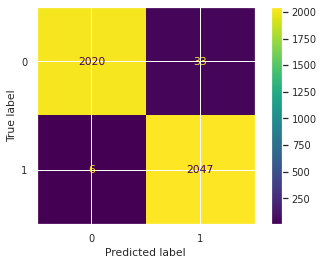

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2053
           1       0.98      1.00      0.99      2053

    accuracy                           0.99      4106
   macro avg       0.99      0.99      0.99      4106
weighted avg       0.99      0.99      0.99      4106

0.9970774476376035


In [ ]:
RF_report(X_train_us2,X_test_us2,y_train_us,y_test_us, 100)

<Figure size 432x288 with 0 Axes>

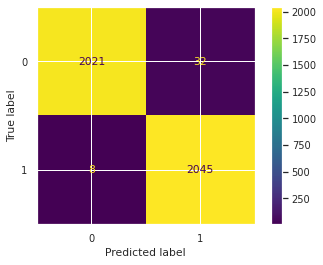

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2053
           1       0.98      1.00      0.99      2053

    accuracy                           0.99      4106
   macro avg       0.99      0.99      0.99      4106
weighted avg       0.99      0.99      0.99      4106

0.9961032635168047


In [ ]:
RF_report(X_train_us2,X_test_us2,y_train_us,y_test_us, 40)

<Figure size 432x288 with 0 Axes>

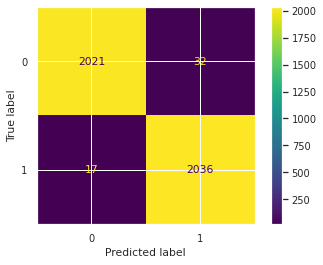

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2053
           1       0.98      0.99      0.99      2053

    accuracy                           0.99      4106
   macro avg       0.99      0.99      0.99      4106
weighted avg       0.99      0.99      0.99      4106

0.9917194349732099


In [ ]:
RF_report(X_train_us2,X_test_us2,y_train_us,y_test_us, 10)

<Figure size 432x288 with 0 Axes>

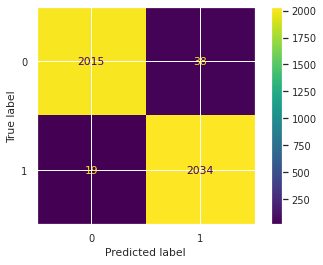

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2053
           1       0.98      0.99      0.99      2053

    accuracy                           0.99      4106
   macro avg       0.99      0.99      0.99      4106
weighted avg       0.99      0.99      0.99      4106

0.990745250852411


In [ ]:
RF_report(X_train_us2,X_test_us2,y_train_us,y_test_us, 5)

<Figure size 432x288 with 0 Axes>

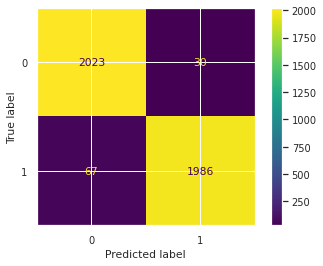

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2053
           1       0.99      0.97      0.98      2053

    accuracy                           0.98      4106
   macro avg       0.98      0.98      0.98      4106
weighted avg       0.98      0.98      0.98      4106

0.9673648319532392


In [ ]:
RF_report(X_train_us2,X_test_us2,y_train_us,y_test_us, 2)

#Conclusiones

Luego de realizar el preprocesamiento del dataset. Fue necesario balancear los variables de input con la de output, para evitar el overfiting. Para esto se utilizó la técnica underfitting sobre la clase mayoritaria.
Se presentaron análisis con 3 modelos diferentes: Logistic Regression, SVM y Random Forest. 

*   Se observa que el mejor desempeño lo presenta el modelo Random Forest, para 5 estimadores, ya que con 10 no se perciben grandes mejorías. Se logra un recall de 99%, con una precisión de 99%.

*   El desempeño más bajo lo presentó SVM con un recall de 69%, independientemente de incorporar o no el momento del día en que se desarrollan los fraudes.

*   El modelo con regresión logística presenta un desempeño muy aceptable, y mejor aún cuando en el dataset se encuentra el feature calculado que especifica el momento del día en que se desarrolla el fraude. 98% fue el recall obtenido con regresión logística.

*   Se resalta que de contrinuir al dataser con una variable calculada, luego de esutidar el problema a analizar mejora el desempeño de los modelos.